# Lesson: Bayesian Hierarchical Linear Regression

You will learn about:

1. Pooled and unpooled models are unsatisfying
    - There are *similarities* between parameters of different groups
    - Pooled and unpooled models unsatisfying answer

2. Partial pooling aka hierarchical modeling
    - Allows for modeling *similarities* but also *differences*
    - Statistical expression
    - PyMC model with Bayesian workflow

3. When things go wrong
    - Divergences - oh my!
    - Reparameterizing our model

4. Hierarchical explorations
  * What does the hierarchy actually *do*?
  * Smart regularization

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# filter out Seaborn UserWarnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'seaborn'
)

In [2]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Species,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
0,Bream,242.0,23.2,11.5200,4.0200,1.391282,2.444085,3.144152,5.488938
1,Bream,290.0,24.0,12.4800,4.3056,1.459917,2.524127,3.178054,5.669881
2,Bream,340.0,23.9,12.3778,4.6961,1.546732,2.515905,3.173878,5.828946
3,Bream,363.0,26.3,12.7300,4.4555,1.494139,2.543961,3.269569,5.894403
4,Bream,430.0,26.5,12.4440,5.1340,1.635885,2.521239,3.277145,6.063785
...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936,0.331890,0.737355,2.442347,2.501436
155,Smelt,13.4,11.7,2.4300,1.2690,0.238229,0.887891,2.459589,2.595255
156,Smelt,12.2,12.1,2.2770,1.2558,0.227773,0.822859,2.493205,2.501436
157,Smelt,19.7,13.2,2.8728,2.0672,0.726195,1.055287,2.580217,2.980619


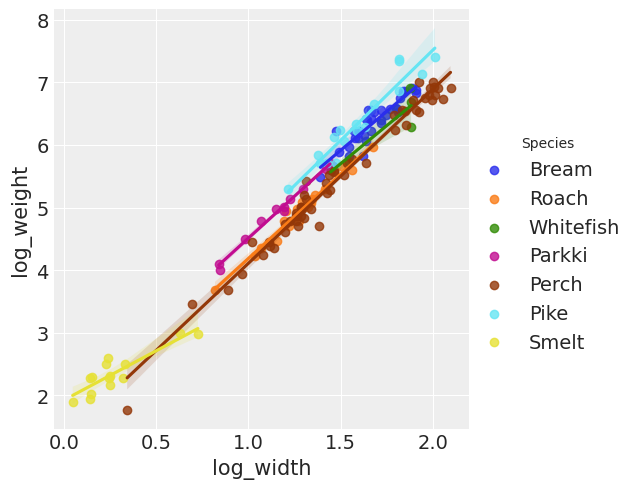

In [140]:
sns.lmplot(
    data=fish_reduced,
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

In [4]:
fish_market.groupby("Species").count()

,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
Species,,,,,,,,
Bream,35,35,35,35,35,35,35,35
Parkki,11,11,11,11,11,11,11,11
Perch,56,56,56,56,56,56,56,56
Pike,17,17,17,17,17,17,17,17
Roach,20,20,20,20,20,20,20,20
Smelt,14,14,14,14,14,14,14,14
Whitefish,6,6,6,6,6,6,6,6


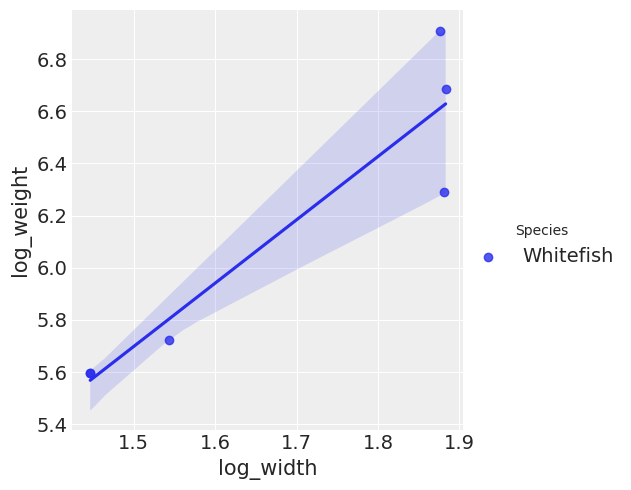

In [141]:
sns.lmplot(
    data=fish_reduced.query("Species == 'Whitefish'"),
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

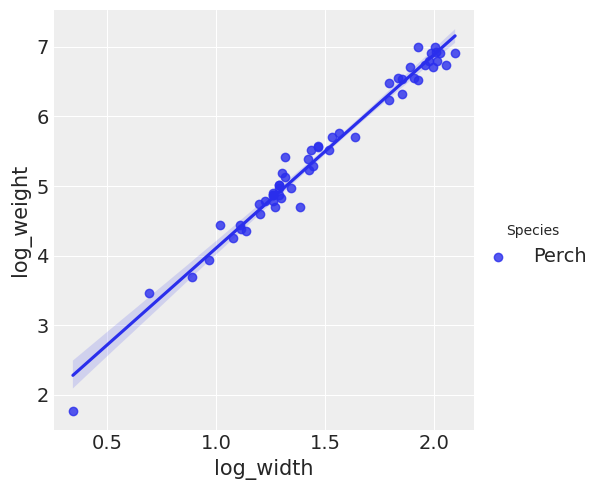

In [142]:
sns.lmplot(
    data=fish_reduced.query("Species == 'Perch'"),
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

In [101]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

species_idx, species = fish_train.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect"], #, "height_effect", "length_effect"],
    "species": species,
}

COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object')}

In [98]:
species_idx_

species_idx{[0 0 0 0 0..5 5 5 5 5]}

In [122]:
fish_train.log_width.values

array([1.3912819 , 1.4599165 , 1.54673238, 1.49413929, 1.63588508,
       1.59481147, 1.66364197, 1.54543258, 1.57769954, 1.60128477,
       1.63006373, 1.57165297, 1.62389293, 1.64302742, 1.71918878,
       1.6649483 , 1.64817774, 1.63584613, 1.74529659, 1.68090239,
       1.66394504, 1.81329262, 1.72080038, 1.80058706, 1.76669804,
       1.82429119, 1.88752409, 1.84154913, 1.83927899, 1.90949806,
       1.90914242, 0.81889839, 1.03733954, 1.06622683, 1.27374137,
       1.22250993, 1.1921937 , 1.32292849, 1.26632769, 1.34032895,
       1.20146967, 1.33500107, 1.28956317, 1.41759921, 1.36251383,
       1.50336603, 1.56310074, 1.6780307 , 1.44635412, 1.44656598,
       1.54363993, 1.88129543, 1.88306163, 1.87564095, 0.84436499,
       0.83906406, 0.98320144, 1.07093272, 1.19222406, 1.22682959,
       1.14965388, 1.29844627, 1.4216615 , 0.34217026, 0.6927471 ,
       0.88871396, 0.96759203, 1.07891966, 1.20044659, 1.13892215,
       1.11080433, 1.01956908, 1.26835506, 1.19619262, 1.26243

In [115]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled_oos:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("species"))

    # linear regression
    mu = pm.Deterministic("mu", intercept[species_idx_] + β[species_idx_] * log_width)
    
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled_oos = pm.sample()
    idata_unpooled_oos.extend(pm.sample_prior_predictive())
    idata_unpooled_oos.extend(pm.sample_posterior_predictive(idata_unpooled_oos))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the t

In [120]:
x = np.linspace(0, 3, 150)

with fish_unpooled_oos:
    pm.set_data({"log_width": x, "log_weight": x})
    pred_x = pm.sample_posterior_predictive(idata_unpooled_oos, var_names=["mu"])


ValueError: Input dimension mismatch. (input[0].shape[0] = 142, input[2].shape[0] = 150)
Apply node that caused the error: Elemwise{Composite{(i0 + (i1 * i2))}}[(0, 0)](AdvancedSubtensor1.0, AdvancedSubtensor1.0, log_width)
Toposort index: 2
Inputs types: [TensorType(float64, (None,)), TensorType(float64, (None,)), TensorType(float64, (None,))]
Inputs shapes: [(142,), (142,), (150,)]
Inputs strides: [(8,), (8,), (8,)]
Inputs values: ['not shown', 'not shown', 'not shown']
Outputs clients: [['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [119]:
pred_x.posterior

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, log_obs_dim_0: 142)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * log_obs_dim_0  (log_obs_dim_0) int64 0 1 2 3 4 5 ... 136 137 138 139 140 141
Data variables:
    log_obs        (chain, draw, log_obs_dim_0) float64 5.792 5.949 ... 3.25
Attributes:
    created_at:                 2022-01-31T05:11:01.482387
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2

In [30]:
mu.eval().shape

(142,)

In [9]:
df_plot = idata_unpooled_oos.posterior["β"].mean(("chain", "draw")).to_dataframe().reset_index()
df_plot.head()

,slopes,species,β
0,width_effect,Bream,0.902306
1,width_effect,Parkki,1.171214
2,width_effect,Perch,0.575930
3,width_effect,Pike,0.810497
4,width_effect,Roach,1.154339


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='β', ylabel='Density'>

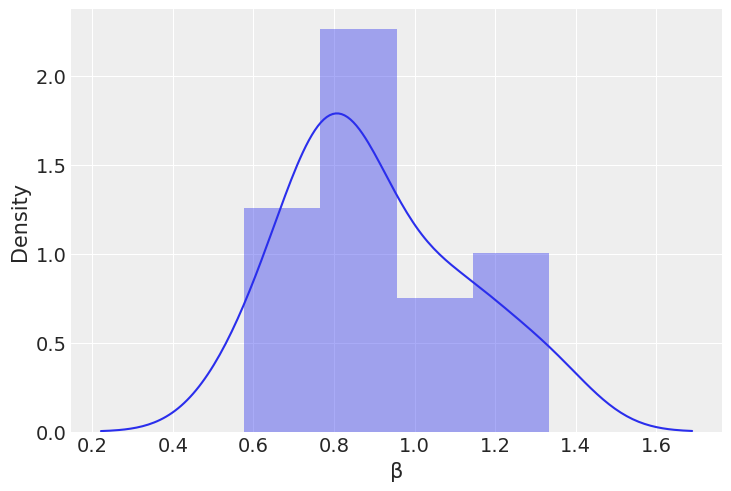

In [10]:
sns.distplot(df_plot["β"])

In [ ]:
idata_unpooled_oos.posterior_predictive

In [ ]:
idata_unpooled_oos.posterior_predictive.log_obs

In [32]:
idata_unpooled_oos.posterior["mu"]

<xarray.DataArray 'mu' (chain: 4, draw: 1000, mu_dim_0: 142)>
array([[[5.62761684, 5.80431209, 5.86671454, ..., 2.46823238,
         3.01084203, 3.0229464 ],
        [5.59965059, 5.79933831, 5.86627521, ..., 2.44343888,
         3.0614562 , 3.04317341],
        [5.65276071, 5.83248253, 5.89258892, ..., 2.49162484,
         2.88402071, 2.90342694],
        ...,
        [5.60043713, 5.7688601 , 5.85896412, ..., 2.54224558,
         2.98823439, 3.0054632 ],
        [5.61545192, 5.79551126, 5.87439942, ..., 2.52203401,
         3.00550036, 3.00538377],
        [5.58636883, 5.75105014, 5.8077504 , ..., 2.38720293,
         2.94383639, 2.94255394]],

       [[5.56078681, 5.73402487, 5.78409613, ..., 2.39474885,
         2.81745787, 2.84005902],
        [5.65076301, 5.81893611, 5.89235162, ..., 2.44976624,
         2.9521664 , 2.97854467],
        [5.68255826, 5.84082525, 5.88256976, ..., 2.39378206,
         2.95844144, 2.91496305],
...
        [5.61614789, 5.80127238, 5.85897705, ..., 2.49925084,
         3.03956284, 3.06265613],
        [5.56085365, 5.75426428, 5.81863684, ..., 2.4923453 ,
         2.94484312, 2.97859158],
        [5.56819274, 5.75451169, 5.85698859, ..., 2.40976373,
         2.96203105, 2.93570249]],

       [[5.57372074, 5.76358478, 5.82134717, ..., 2.41181783,
         2.90343668, 2.88463401],
        [5.70028578, 5.88494433, 5.94827659, ..., 2.49982206,
         2.99954827, 3.01014236],
        [5.62629129, 5.82535367, 5.93809877, ..., 2.40223593,
         2.96667723, 2.93561727],
        ...,
        [5.57822807, 5.75527672, 5.82653626, ..., 2.42121361,
         2.96693078, 2.95467379],
        [5.63147738, 5.81366058, 5.86902335, ..., 2.44889773,
         3.0021288 , 2.98915188],
        [5.64166458, 5.82669454, 5.88448439, ..., 2.43783553,
         2.9764194 , 2.9644271 ]]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 135 136 137 138 139 140 141

In [89]:
x = np.linspace(0, 3, 150)

In [74]:
idata_unpooled_oos.posterior["intercept"].sel(species="Whitefish", chain=0, draw=i).data

array(-0.61532908)

In [81]:
idata_unpooled_oos.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, species: 7, slopes: 3, mu_dim_0: 142)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * species    (species) <U9 'Bream' 'Parkki' 'Perch' ... 'Smelt' 'Whitefish'
  * slopes     (slopes) <U13 'width_effect' 'height_effect' 'length_effect'
  * mu_dim_0   (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 135 136 137 138 139 140 141
Data variables:
    intercept  (chain, draw, species) float64 -0.1434 -0.4905 ... -0.4932
    β          (chain, draw, slopes, species) float64 0.8616 0.9532 ... 1.106
    sigma      (chain, draw) float64 0.09004 0.08328 0.09099 ... 0.099 0.09815
    mu         (chain, draw, mu_dim_0) float64 5.628 5.804 5.867 ... 2.976 2.964
Attributes:
    created_at:                 2022-01-31T04:37:38.947287
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              79.02495098114014
    tuning_steps:               1000

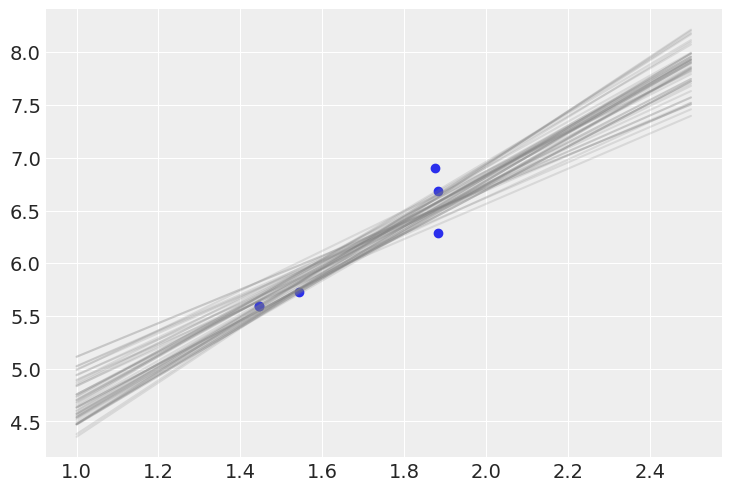

In [143]:
def plot_pred(species="Whitefish"):
    x = np.linspace(1.0, 2.5, 150)
    fish_spec = fish_reduced[fish_reduced.Species == species]
    ys = []
    for i in range(100, 150):
        y = idata_unpooled_oos.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (x * idata_unpooled_oos.posterior["β"].sel(species=species, chain=0, draw=i).data) # + (x * idata_unpooled_oos.posterior["β"].sel(species=spec, slopes="height_effect", chain=0, draw=i).data) + (x * idata_unpooled_oos.posterior["β"].sel(species=spec, slopes="length_effect", chain=0, draw=i).data)# (x[:, np.newaxis] * idata_unpooled_oos.posterior["β"].sel(species=spec, chain=0, draw=i).data).sum(1)
        #y = idata_unpooled_oos.posterior["interce'pt"].sel(species=spec, chain=0, draw=i).data + (x[:, np.newaxis] * idata_unpooled_oos.posterior["β"].sel(species=spec, chain=0, draw=i).data).sum(1)
        ys.append(y)
        plt.plot(x, y, color=".5", alpha=.2)

    plt.scatter(fish_spec["log_width"], fish_spec["log_weight"])
    
plot_pred()

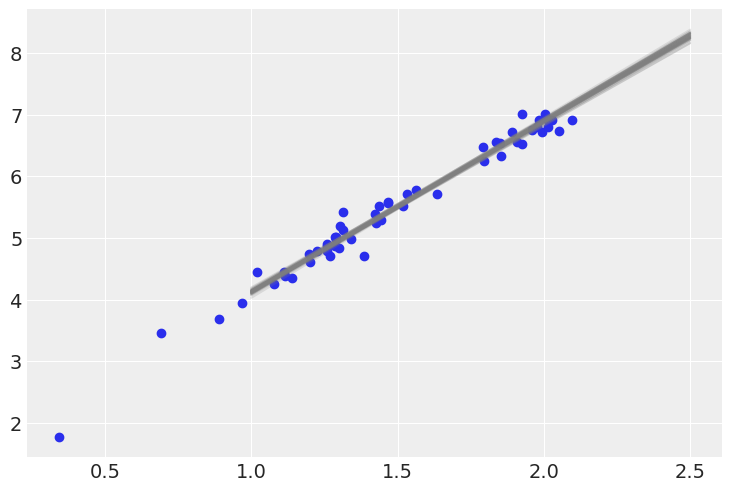

In [144]:
plot_pred(species="Perch")

ValueError: x and y must have same first dimension, but have shapes (150,) and (10, 150)

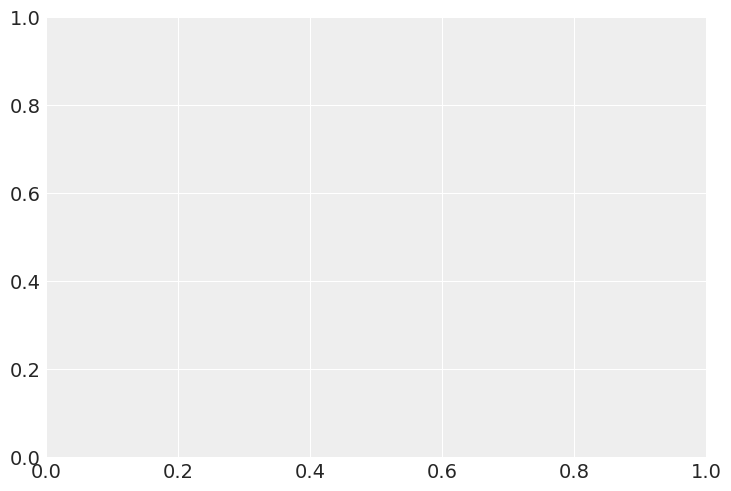

In [63]:
fish_white = fish_reduced.query("Species == 'Whitefish'")
plt.plot(x, ys)
plt.scatter(fish_white["log_width"], fish_white["log_weight"])

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='intercept', ylabel='Density'>

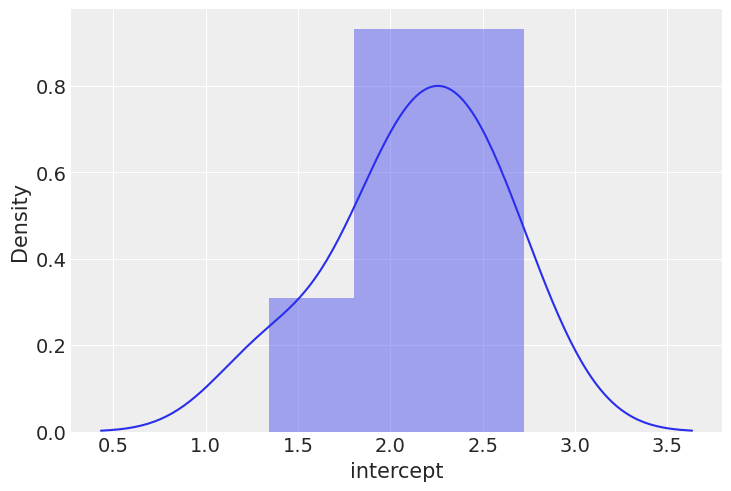

In [137]:
df_plot = idata_unpooled_oos.posterior["intercept"].mean(("chain", "draw")).to_dataframe().reset_index()
sns.distplot(df_plot["intercept"])

In [138]:
g = sns.FacetGrid(data=df_plot, col="slopes", col_wrap=3)
g.map(sns.distplot, "β", kde=False)

KeyError: 'slopes'

In [148]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical:
    # data
    log_width = pm.ConstantData("log_width", fish_train.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=1.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=1.0)
    intercept = pm.Normal("intercept", mu=group_intercept_mu,
                          sigma=group_intercept_sigma, dims="species")
    
    group_β_mu = pm.Normal("group_β_mu", sigma=5.0)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.5)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, 
                  dims=("species"))

    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample()
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [126]:
group_β_mu.eval()

array(-0.22066636)

In [128]:
β.eval().shape

(7,)

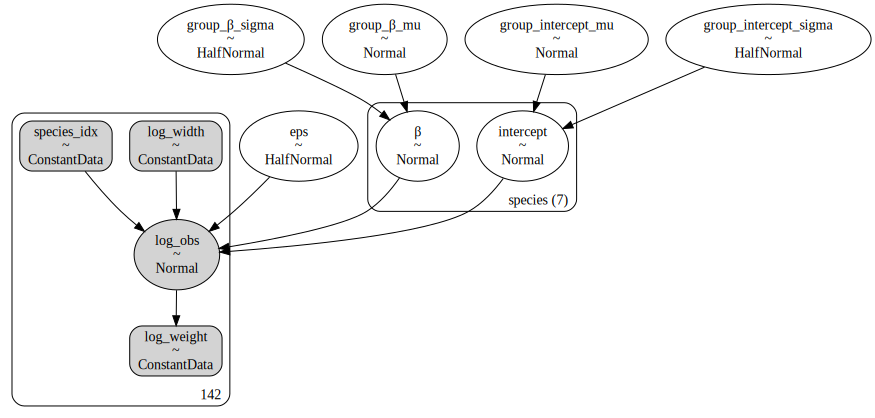

In [136]:
pm.model_to_graphviz(fish_hierarchical)

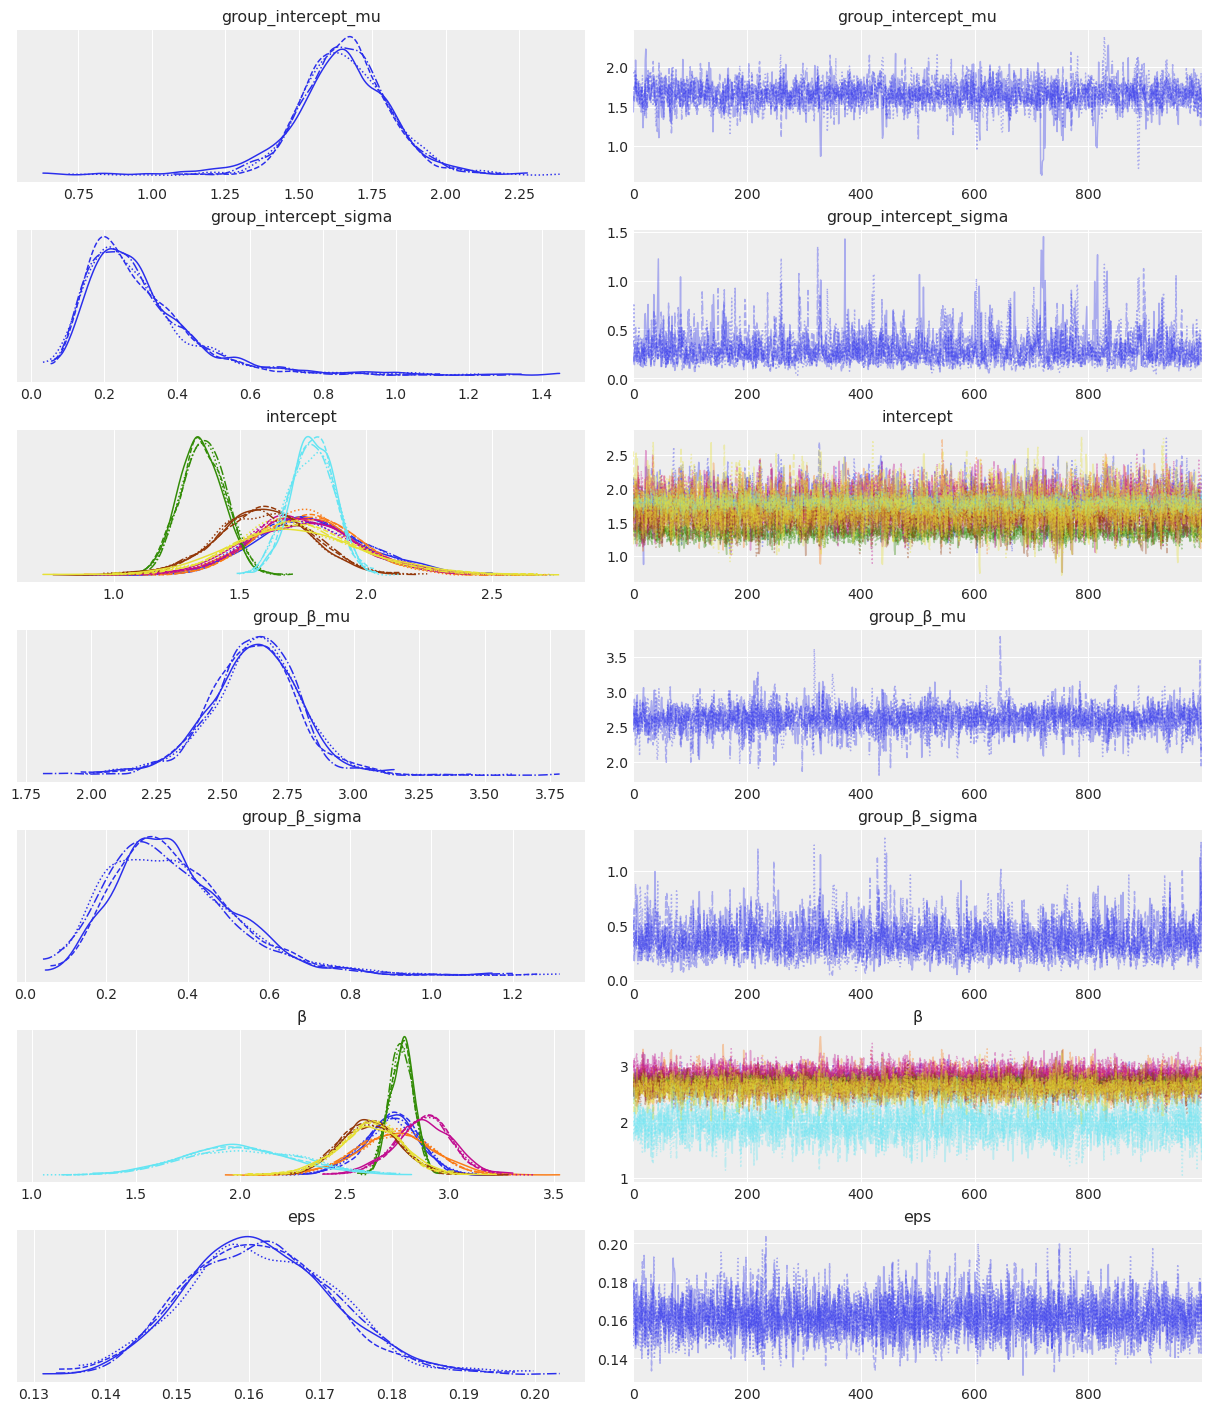

In [149]:
az.plot_trace(idata_hierarchical);

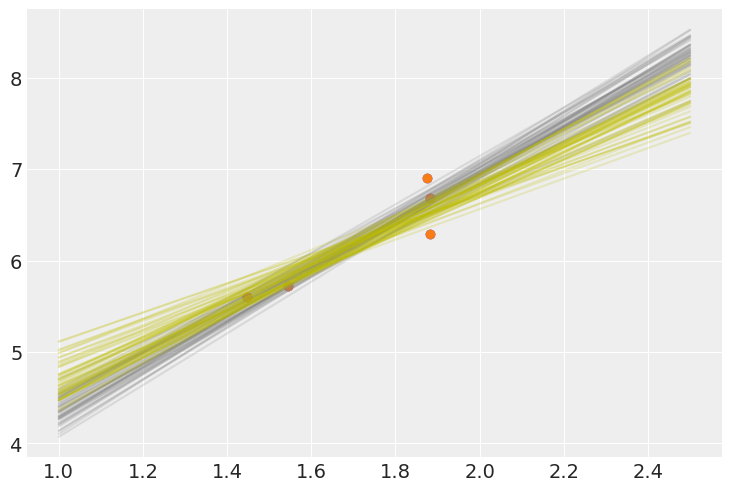

In [150]:
def plot_pred(idata, species="Whitefish", color="0.5"):
    x = np.linspace(1.0, 2.5, 150)
    fish_spec = fish_reduced[fish_reduced.Species == species]
    ys = []
    for i in range(100, 150):
        y = idata.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (x * idata.posterior["β"].sel(species=species, chain=0, draw=i).data) # + (x * idata_unpooled_oos.posterior["β"].sel(species=spec, slopes="height_effect", chain=0, draw=i).data) + (x * idata_unpooled_oos.posterior["β"].sel(species=spec, slopes="length_effect", chain=0, draw=i).data)# (x[:, np.newaxis] * idata_unpooled_oos.posterior["β"].sel(species=spec, chain=0, draw=i).data).sum(1)
        #y = idata_unpooled_oos.posterior["interce'pt"].sel(species=spec, chain=0, draw=i).data + (x[:, np.newaxis] * idata_unpooled_oos.posterior["β"].sel(species=spec, chain=0, draw=i).data).sum(1)
        ys.append(y)
        plt.plot(x, y, color=color, alpha=.2)

    plt.scatter(fish_spec["log_width"], fish_spec["log_weight"])

plot_pred(idata_hierarchical)
plot_pred(idata_unpooled_oos, color="y")

In [63]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical_nc:
    # data
    log_width = pm.Data("log_width", fish_train.log_width.values)
    log_height = pm.Data("log_height", fish_train.log_height.values)
    log_length = pm.Data("log_length", fish_train.log_length.values)
    log_weight = pm.Data("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=5.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=.1)
    intercept = pm.Normal("intercept", dims="species") * group_intercept_sigma + group_intercept_mu
    
    group_β_mu = pm.Normal("group_β_mu", sigma=3.5)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.05)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, dims=("species", "slopes")) #*  + group_β_mu

    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * log_width
        + β[species_idx_, 1] * log_height
        + β[species_idx_, 2] * log_length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample(init="jitter+adapt_diag", tune=1000, target_accept=0.9)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

/Users/twiecki/projects/pymc/pymc/data.py:640: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `ta

There is a good sign here: the posterior uncertainty around `sigma` is much lower than before, i.e we picked up much more information on the fish weights. But did this improve our posterior predictions?

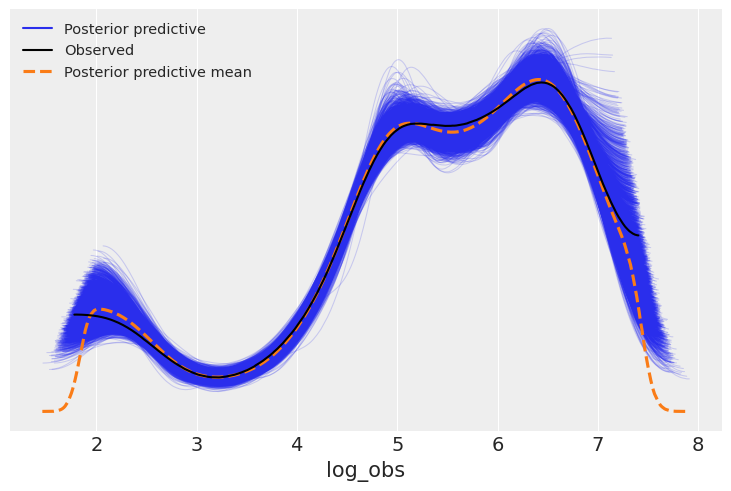

In [13]:
ax = az.plot_ppc(idata_hierarchical)
ax.set_xlabel("log_obs");

Well that's much better! Our model is now able to pick up the differences between species. And we could do even better: again, we didn't think seriously about out priors:

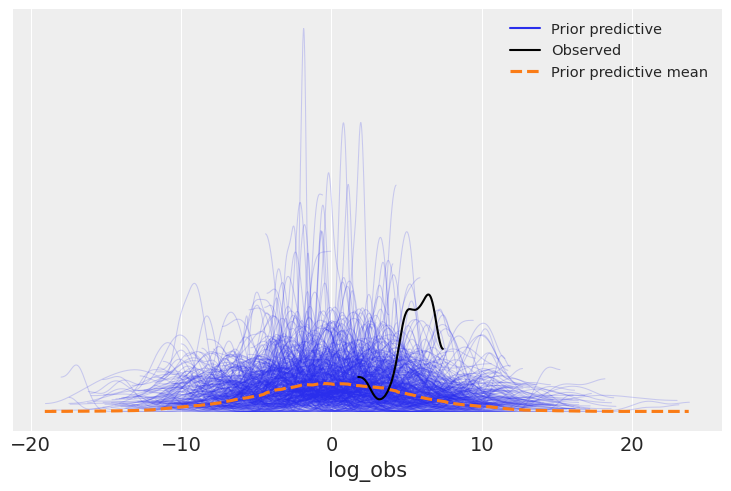

In [14]:
ax = az.plot_ppc(idata_hierarchical, group="prior")
ax.set_xlabel("log_obs");

Other than that, the model is _exactly_ the same as before:

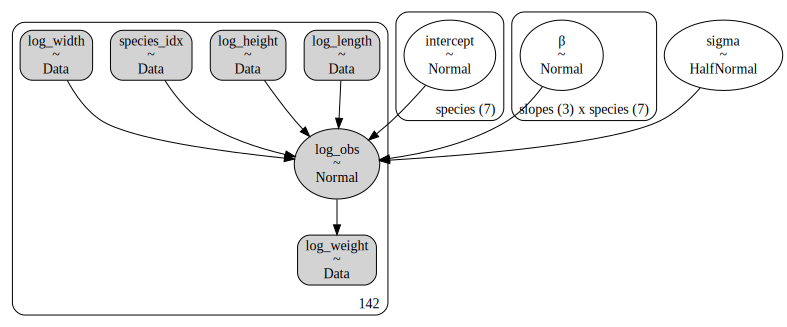

In [34]:
pm.model_to_graphviz(fish_unpooled_oos)

In [37]:
with fish_unpooled_oos:
    # update values of predictors:
    pm.set_data(
        {
            "log_height": fish_test.log_height.values,
            "log_length": fish_test.log_length.values,
            "log_width": fish_test.log_width.values,
            "species_idx": fish_test.Species.factorize(sort=True)[0],
        }
    )

Once that's done, we can just call `sample_posterior_predictive`. The only difference is that we're telling PyMC these are really predictions (`predictions=True`), and we want them appended to our existing `InferenceData` object (`extend_inferencedata=True`).

In [38]:
with fish_unpooled_oos:
    # use the updated values to predict outcomes:
    idata_unpooled_oos = pm.sample_posterior_predictive(
        idata_unpooled_oos,
        predictions=True,
        extend_inferencedata=True,  # not released yet, needs main branch
    )

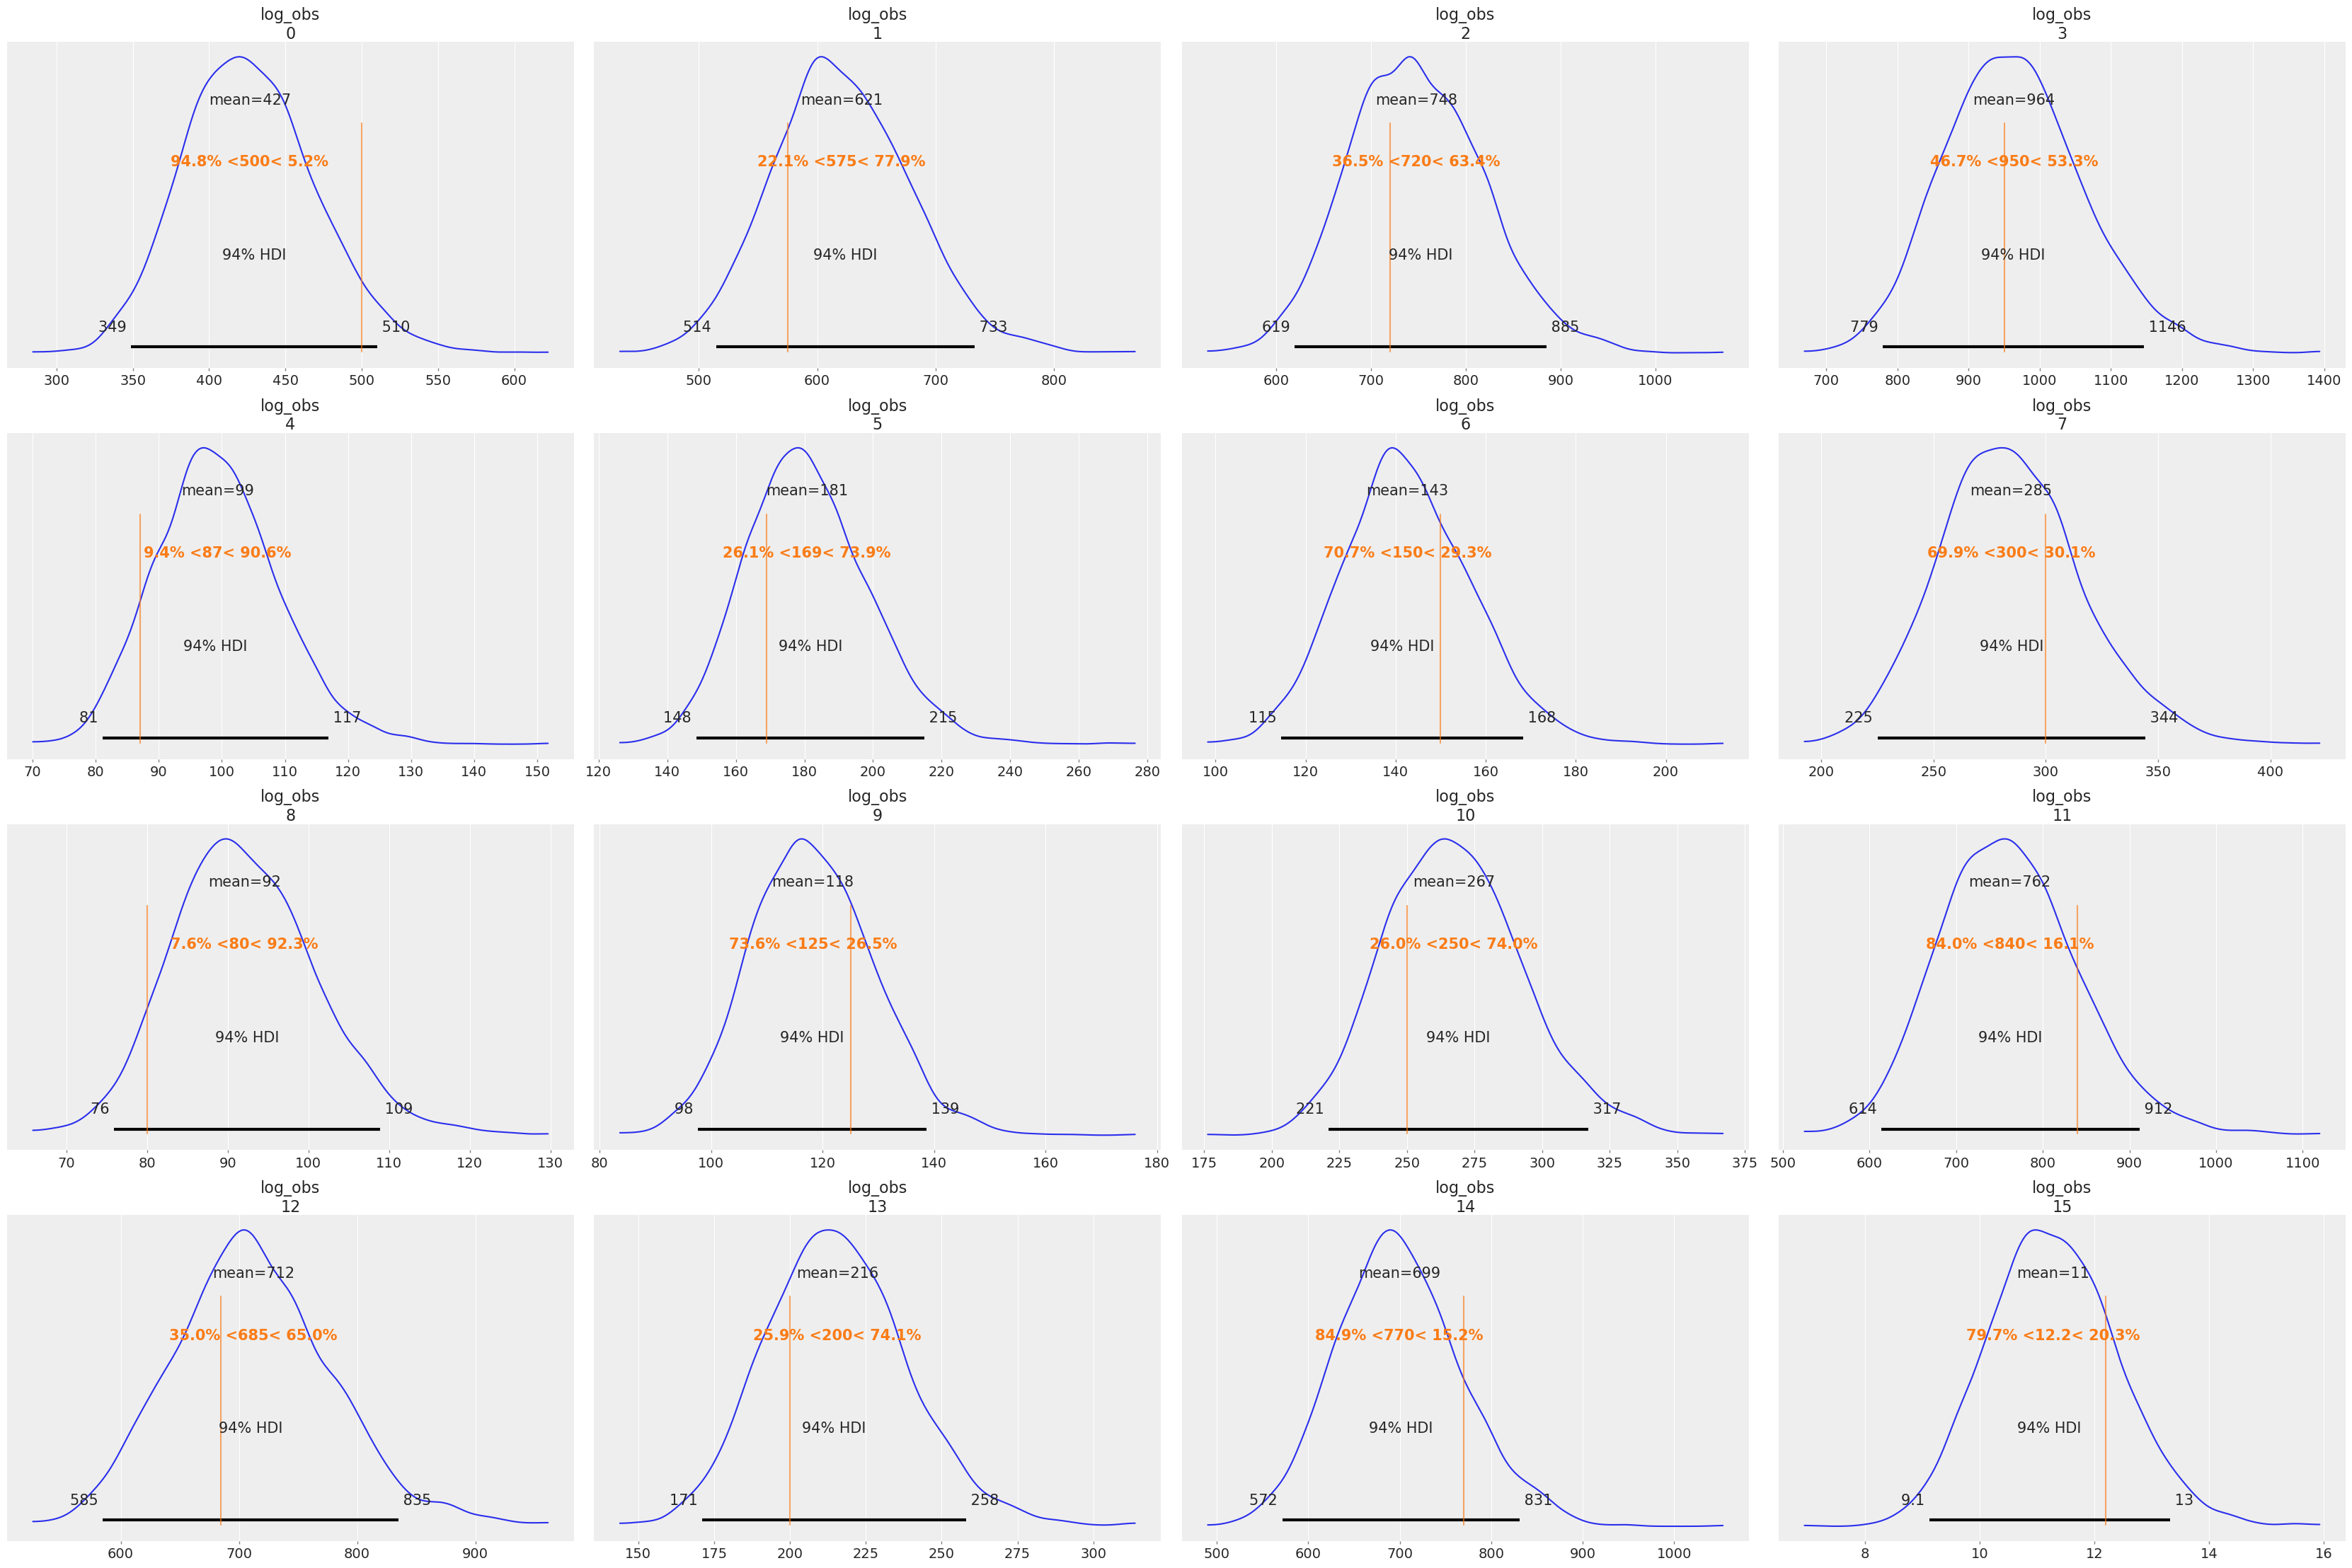

In [40]:
az.plot_posterior(
    idata_unpooled_oos.predictions,
    ref_val=fish_test["Weight"].tolist(),
    transform=np.exp,
);

Look at that beauty! The model did an excellent job predicting those new weights: the true value is inside the inferred posterior distribution for _every_ new data point, without extremely small probabilities.

### Section recap

- Use `pm.set_data` to update the values of predictors
- `pm.sample_posterior_predictive(predictions=True, extend_inferencedata=True)` uses the updated values to predict outcomes and appends them to the original `InferenceData` object
- `az.plot_posterior` is an easy and concise way to check the quality of and uncertainty in those predictions

## From predictions to business insights

Last step: remember what we said at the beginning? There are different price tiers for weights, and those tiers can get _really_ expensive, so we want to know the probability of an item being above any theshold. Since we have posterior samples, we can actually compute that probability for all the new fish we observed.

As in the previous plot, we'll exponentiate the predictions, so that we're on the data scale. The new thing is that, for each new fish, we'll compute the probability that it's above any of the four threshold.

How do we do that? We just count, as you saw in the first lesson! For each posterior prediction, we check if it's below the threshold. If it is, the value `True` is recorded; if it's not, then it's `False`. For instance, if the threshold is 250:

In [135]:
predictions = np.exp(idata_unpooled_oos.predictions)

In [139]:
threshold = 250
(predictions >= threshold)

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, log_obs_dim_0: 16)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * log_obs_dim_0  (log_obs_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    log_obs        (chain, draw, log_obs_dim_0) bool True True ... True False
Attributes:
    created_at:                 2022-01-07T11:31:03.996790
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b1

Then, we just have to take the mean of this object across chains and draws, and it's our probability!

## Lesson recap